<a href="https://colab.research.google.com/github/sachin2967/Mumbai_Rainfall_Prediction_MLvsDL/blob/main/final_stat_ml_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Setup and Installation
!pip install pandas numpy matplotlib seaborn scikit-learn torch ipython-autotime -q
%load_ext autotime

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Load data
print("Loading data...")
raw_df = pd.read_csv('cleaned_data.csv')

# Display basic information
print("\nData Shape:", raw_df.shape)
print("\nSample Data:")
print(raw_df.head())

# Check for missing values
print("\nMissing Values Summary:")
print(raw_df.isna().sum())


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
Loading data...

Data Shape: (383640, 17)

Sample Data:
  Observed Location                 Time Day  Temperature  Weather Icon  \
0            Mumbai  2009-10-01 00:10:00   N         29.0            15   
1            Mumbai  2009-10-01 00:40:00   N         29.0            15   
2            Mumbai  2009-10-01 01:10:00   N         29.0            15   
3            Mumbai  2009-10-01 01:40:00   N         29.0            15   
4            Mumbai  2009-10-01 02:10:00   N         29.0            15   

  Weather Phrase  Dew Point  Heat Index  Relative Humidity  Pressure  \
0  Partly Cloudy       27.0        37.0               89.0   1004.52   
1  Partly Cloudy       27.0        37.0               89.0   1004.52   
2  Partly Cloudy       27.0        37.0               89.0   1003.52   
3  Partly Cloudy       27.0        37.0               89.0   1003.52   
4  Partly Cloudy       27.0        37.0          

In [ ]:
raw_df.head()

,Observed Location,Time,Day,Temperature,Weather Icon,Weather Phrase,Dew Point,Heat Index,Relative Humidity,Pressure,Visibility,Wind Chill,Wind Direction,Wind Cardinal,UV Index,UV Description,Feels Like
0,Mumbai,2009-10-01 00:10:00,N,29.0,15,Partly Cloudy,27.0,37.0,89.0,1004.52,3.0,29.0,260.0,W,0,Low,37.0
1,Mumbai,2009-10-01 00:40:00,N,29.0,15,Partly Cloudy,27.0,37.0,89.0,1004.52,3.0,29.0,240.0,WSW,0,Low,37.0
2,Mumbai,2009-10-01 01:10:00,N,29.0,15,Partly Cloudy,27.0,37.0,89.0,1003.52,3.0,29.0,0.0,CALM,0,Low,37.0
3,Mumbai,2009-10-01 01:40:00,N,29.0,15,Partly Cloudy,27.0,37.0,89.0,1003.52,3.0,29.0,220.0,SW,0,Low,37.0
4,Mumbai,2009-10-01 02:10:00,N,29.0,15,Partly Cloudy,27.0,37.0,89.0,1003.52,3.0,29.0,240.0,WSW,0,Low,37.0


time: 16 ms (started: 2025-03-31 12:37:42 +00:00)


In [ ]:
import pandas as pd

def preprocess_data(raw_df):
    """
    Process weather data for rain prediction modeling.
    """
    print("Preprocessing data...")
    df = raw_df.copy()

    # Convert Time to datetime and ensure correct range
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    df = df.dropna(subset=['Time'])

    # # Ensure the dataset only contains data from 2009 onwards
    # df = df[df['Time'].dt.year >= 2009]

    # Extract date and time components
    df['Date'] = df['Time'].dt.date
    df['Hour'] = df['Time'].dt.hour
    df['Month'] = df['Time'].dt.month
    df['Day_of_Week'] = df['Time'].dt.dayofweek
    df['Season'] = df['Month'] % 12 // 3 + 1  # 1: Spring, 2: Summer, 3: Fall, 4: Winter

    # Create morning (8-10 AM) and afternoon (2-4 PM) aggregations
    morning = df[df['Hour'].isin([8, 9, 10])]
    afternoon = df[df['Hour'].isin([14, 15, 16])]

    # Ensure we only use dates with both morning and afternoon data
    valid_dates = set(morning['Date']).intersection(set(afternoon['Date']))
    df = df[df['Date'].isin(valid_dates)]

    # Create daily dataframe
    daily_df = pd.DataFrame({'Date': sorted(valid_dates)})
    daily_df.set_index('Date', inplace=True)

    # Aggregate numerical features
    numerical_features = [
        'Temperature', 'Dew Point', 'Relative Humidity',
        'Pressure', 'Visibility'
    ]

    for feature in numerical_features:
        if feature in df.columns:
            daily_df[f'{feature}_9am'] = morning.groupby('Date')[feature].mean()
            daily_df[f'{feature}_3pm'] = afternoon.groupby('Date')[feature].mean()


    # Create rain indicator based on Weather Phrase
    rain_phrases = ['Light Rain', 'Rain', 'Heavy Rain', 'Drizzle',
                    'Heavy Drizzle', 'Showers', 'Thunder', 'T-Storm']

    df_filtered = df[df['Date'].isin(valid_dates)]
    daily_weather = df_filtered.groupby('Date')['Weather Phrase'].agg(lambda x: list(set(x)))

    daily_df['RainToday'] = daily_weather.apply(
        lambda x: 1 if any(rain in phrase for phrase in x for rain in rain_phrases) else 0
    )

    # Create target variable: RainTomorrow
    daily_df['RainTomorrow'] = daily_df['RainToday'].shift(-1)

    # Add seasonality features
    daily_df['Month'] = daily_df.index.map(lambda x: x.month)
    daily_df['Day_of_Week'] = daily_df.index.map(lambda x: x.weekday())
    daily_df['Season'] = daily_df.index.map(lambda x: x.month % 12 // 3 + 1)

    # Drop rows with missing values and reset index
    daily_df_final = daily_df.dropna().reset_index()

    print(f"Preprocessed data shape: {daily_df_final.shape}")
    print(f"Data range: {daily_df_final['Date'].min()} to {daily_df_final['Date'].max()}")

    return daily_df_final

# Preprocess the data
processed_df = preprocess_data(raw_df)


Preprocessing data...
Preprocessed data shape: (9722, 16)
Data range: 1997-01-02 to 2024-10-26
time: 1.76 s (started: 2025-03-31 12:37:42 +00:00)


In [ ]:
processed_df['Date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 9722 entries, 0 to 9721
Series name: Date
Non-Null Count  Dtype 
--------------  ----- 
9722 non-null   object
dtypes: object(1)
memory usage: 76.1+ KB
time: 8.15 ms (started: 2025-03-31 12:37:44 +00:00)


In [ ]:
processed_df.head()

,Date,Temperature_9am,Temperature_3pm,Dew Point_9am,Dew Point_3pm,Relative Humidity_9am,Relative Humidity_3pm,Pressure_9am,Pressure_3pm,Visibility_9am,Visibility_3pm,RainToday,RainTomorrow,Month,Day_of_Week,Season
0,1997-01-02,28.000000,28.666667,11.0,16.333333,35.000000,47.000000,1014.520000,1010.520000,5.000000,2.000000,0,0.0,1,3,1
1,1997-01-03,25.000000,28.833333,13.0,14.500000,47.600000,41.833333,1013.320000,1010.186667,2.000000,4.666667,0,0.0,1,4,1
2,1997-01-04,23.833333,27.000000,14.5,15.666667,56.333333,50.000000,1014.353333,1011.186667,1.133333,5.833333,0,0.0,1,5,1
3,1997-01-05,22.666667,27.333333,15.0,15.833333,62.333333,49.500000,1013.853333,1009.686667,1.466667,3.000000,0,0.0,1,6,1
4,1997-01-06,24.000000,28.400000,15.4,17.200000,59.000000,50.400000,1012.920000,1009.520000,1.400000,2.000000,0,0.0,1,0,1


time: 66.5 ms (started: 2025-03-31 12:37:44 +00:00)


In [ ]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9722 entries, 0 to 9721
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   9722 non-null   object 
 1   Temperature_9am        9722 non-null   float64
 2   Temperature_3pm        9722 non-null   float64
 3   Dew Point_9am          9722 non-null   float64
 4   Dew Point_3pm          9722 non-null   float64
 5   Relative Humidity_9am  9722 non-null   float64
 6   Relative Humidity_3pm  9722 non-null   float64
 7   Pressure_9am           9722 non-null   float64
 8   Pressure_3pm           9722 non-null   float64
 9   Visibility_9am         9722 non-null   float64
 10  Visibility_3pm         9722 non-null   float64
 11  RainToday              9722 non-null   int64  
 12  RainTomorrow           9722 non-null   float64
 13  Month                  9722 non-null   int64  
 14  Day_of_Week            9722 non-null   int64  
 15  Seas


Performing Exploratory Data Analysis...


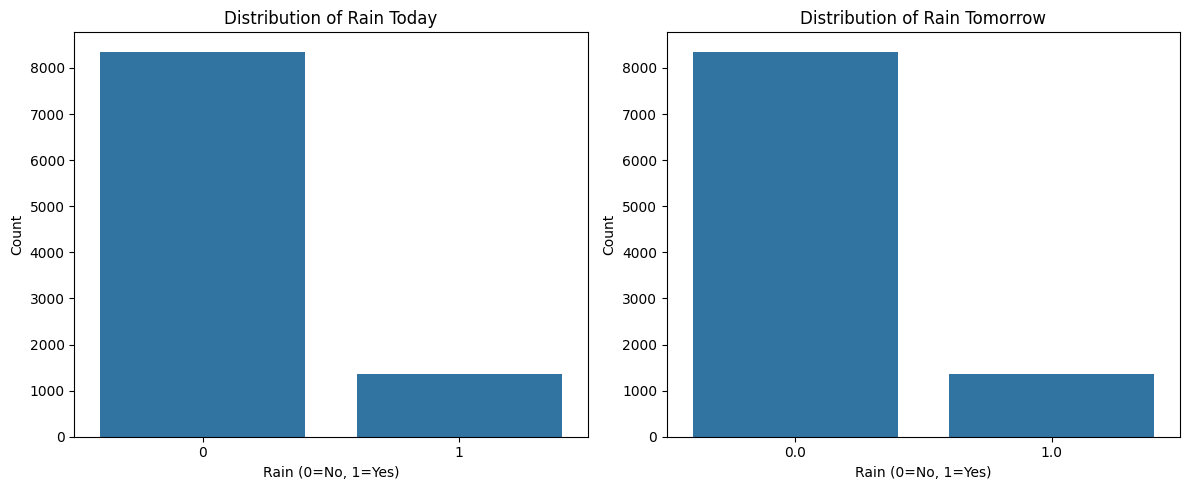

Rain Today: 14.06% of days
Rain Tomorrow: 14.06% of days


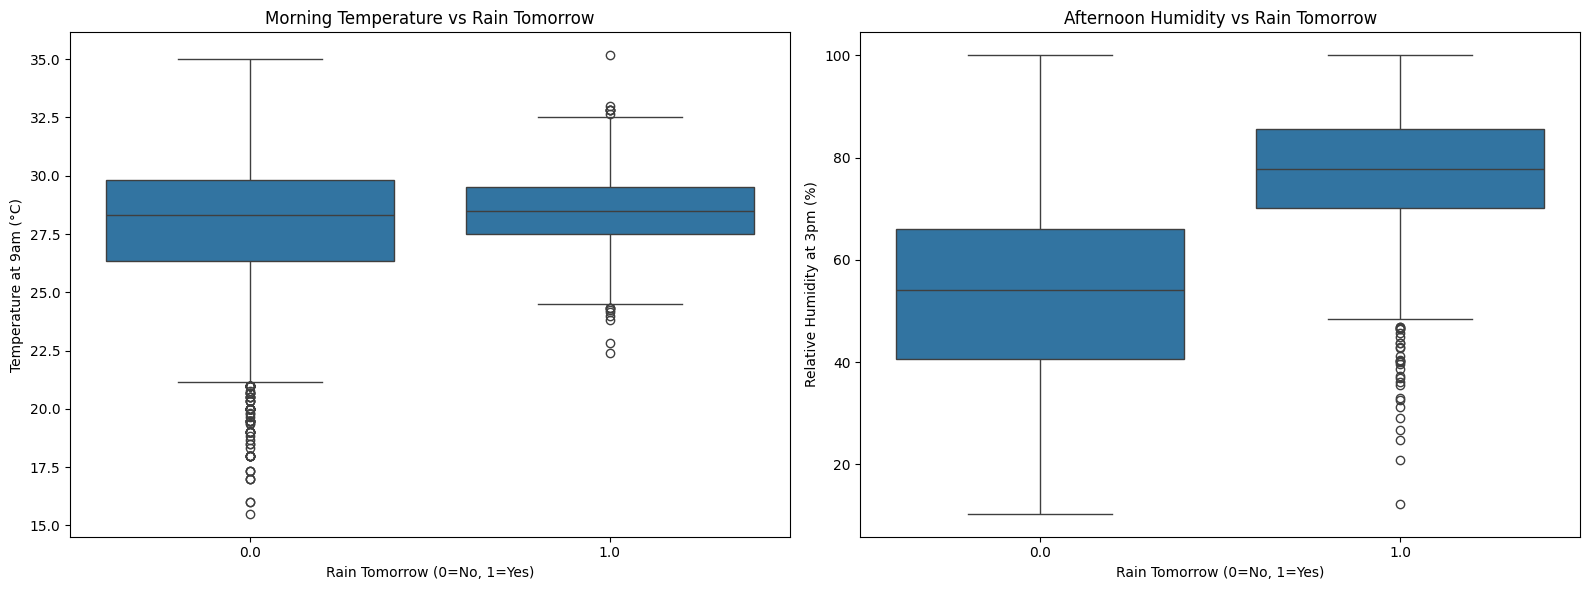

time: 864 ms (started: 2025-03-31 12:37:44 +00:00)


In [ ]:
def perform_eda(df):
    """
    Perform exploratory data analysis on the processed dataset
    """
    print("\nPerforming Exploratory Data Analysis...")

    # Plot 1: Distribution of Rain Today and Rain Tomorrow
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x='RainToday', data=df)
    plt.title('Distribution of Rain Today')
    plt.xlabel('Rain (0=No, 1=Yes)')
    plt.ylabel('Count')

    plt.subplot(1, 2, 2)
    sns.countplot(x='RainTomorrow', data=df)
    plt.title('Distribution of Rain Tomorrow')
    plt.xlabel('Rain (0=No, 1=Yes)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    # Calculate the class distribution percentages
    rain_today_pct = df['RainToday'].mean() * 100
    rain_tomorrow_pct = df['RainTomorrow'].mean() * 100

    print(f"Rain Today: {rain_today_pct:.2f}% of days")
    print(f"Rain Tomorrow: {rain_tomorrow_pct:.2f}% of days")

    # Plot 2: Temperature and Humidity vs Rain Tomorrow
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='RainTomorrow', y='Temperature_9am', data=df)
    plt.title('Morning Temperature vs Rain Tomorrow')
    plt.xlabel('Rain Tomorrow (0=No, 1=Yes)')
    plt.ylabel('Temperature at 9am (°C)')

    plt.subplot(1, 2, 2)
    sns.boxplot(x='RainTomorrow', y='Relative Humidity_3pm', data=df)
    plt.title('Afternoon Humidity vs Rain Tomorrow')
    plt.xlabel('Rain Tomorrow (0=No, 1=Yes)')
    plt.ylabel('Relative Humidity at 3pm (%)')
    plt.tight_layout()
    plt.show()

    # # Plot 3: Pressure and Temperature Difference vs Rain Tomorrow
    # plt.figure(figsize=(16, 6))
    # plt.subplot(1, 2, 1)
    # sns.boxplot(x='RainTomorrow', y='Pressure_diff', data=df)
    # plt.title('Pressure Difference (3pm-9am) vs Rain Tomorrow')
    # plt.xlabel('Rain Tomorrow (0=No, 1=Yes)')
    # plt.ylabel('Pressure Difference (hPa)')

    # plt.subplot(1, 2, 2)
    # sns.boxplot(x='RainTomorrow', y='Temperature_diff', data=df)
    # plt.title('Temperature Difference (3pm-9am) vs Rain Tomorrow')
    # plt.xlabel('Rain Tomorrow (0=No, 1=Yes)')
    # plt.ylabel('Temperature Difference (°C)')
    # plt.tight_layout()
    # plt.show()

    # # Plot 4: Monthly Distribution of Rain
    # plt.figure(figsize=(12, 6))
    # monthly_rain = df.groupby('Month')['RainTomorrow'].mean() * 100
    # monthly_rain.plot(kind='bar', color='skyblue')
    # plt.title('Monthly Rainfall Probability')
    # plt.xlabel('Month')
    # plt.ylabel('Rain Probability (%)')
    # plt.xticks(rotation=45)
    # plt.tight_layout()
    # plt.show()

# Perform EDA
perform_eda(processed_df)


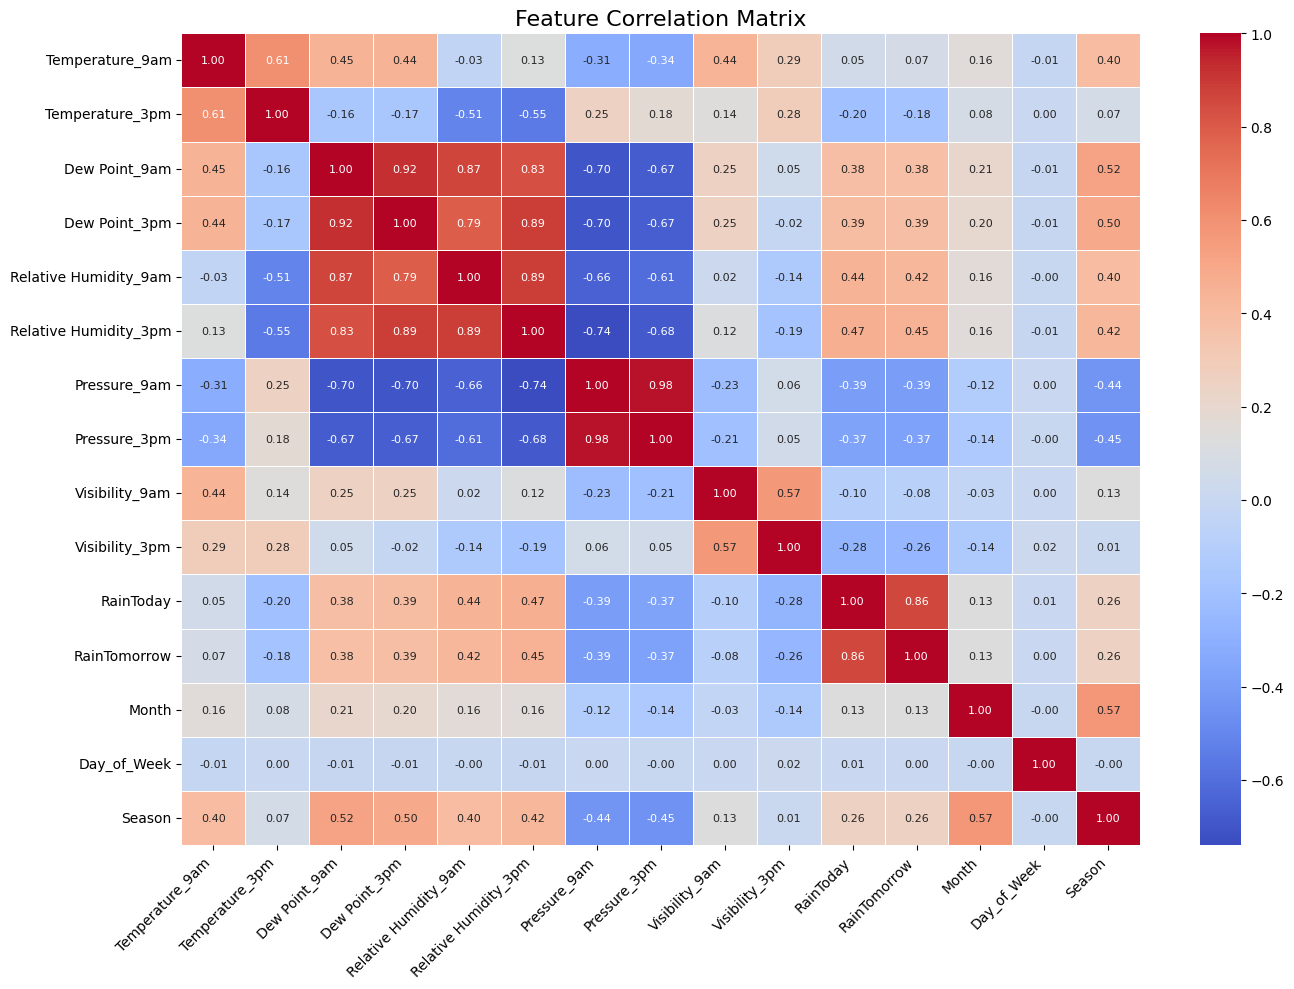

time: 923 ms (started: 2025-03-31 12:37:45 +00:00)


In [ ]:
# Compute correlation matrix (exclude non-numeric columns)
numerical_cols = processed_df.select_dtypes(include=['number']).columns
corr_matrix = processed_df[numerical_cols].corr()

# # Display the correlation matrix
# print("Correlation Matrix:\n", corr_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            cbar=True, annot_kws={"size": 8}, linewidths=0.5)
plt.title("Feature Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def temporal_split_balanced(df, val_size=0.15, test_size=0.15):
    """
    Perform temporal data split while ensuring class balance.
    """
    print("\nPerforming temporal data split with class balance...")

    # Sort data by date
    df_sorted = df.sort_values('Date')

    # Split data separately for each class (RainTomorrow = 0 and 1)
    df_class_0 = df_sorted[df_sorted['RainTomorrow'] == 0]
    df_class_1 = df_sorted[df_sorted['RainTomorrow'] == 1]

    # Function to split each class separately
    def split_class_data(class_df):
        n = len(class_df)
        test_split = int(n * (1 - test_size))
        val_split = int(test_split * (1 - val_size))

        train = class_df.iloc[:val_split]
        val = class_df.iloc[val_split:test_split]
        test = class_df.iloc[test_split:]

        return train, val, test

    # Split class 0 and class 1 data separately
    train_0, val_0, test_0 = split_class_data(df_class_0)
    train_1, val_1, test_1 = split_class_data(df_class_1)

    # Merge both classes while maintaining temporal order
    train = pd.concat([train_0, train_1]).sort_values('Date')
    val = pd.concat([val_0, val_1]).sort_values('Date')
    test = pd.concat([test_0, test_1]).sort_values('Date')

    # Display dataset info
    print(f"Train set: {len(train)} samples ({train['RainTomorrow'].value_counts(normalize=True).to_dict()})")
    print(f"Validation set: {len(val)} samples ({val['RainTomorrow'].value_counts(normalize=True).to_dict()})")
    print(f"Test set: {len(test)} samples ({test['RainTomorrow'].value_counts(normalize=True).to_dict()})")

    return train, val, test

# Perform the balanced split
train_df, val_df, test_df = temporal_split_balanced(processed_df)

# Prepare X and y sets
X_train = train_df.drop(columns=['Date', 'RainToday', 'RainTomorrow'])
y_train = train_df['RainTomorrow']
X_val = val_df.drop(columns=['Date', 'RainToday', 'RainTomorrow'])
y_val = val_df['RainTomorrow']
X_test = test_df.drop(columns=['Date', 'RainToday', 'RainTomorrow'])
y_test = test_df['RainTomorrow']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to preserve feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)



Performing temporal data split with class balance...
Train set: 7021 samples ({0.0: 0.8595641646489104, 1.0: 0.14043583535108958})
Validation set: 1241 samples ({0.0: 0.8589846897663175, 1.0: 0.14101531023368252})
Test set: 1460 samples ({0.0: 0.8589041095890411, 1.0: 0.1410958904109589})
time: 38.8 ms (started: 2025-03-31 12:37:46 +00:00)


In [ ]:
def train_logistic_regression(X_train, y_train, X_val, y_val):
    """Train and evaluate Logistic Regression model"""
    print("\n==== Logistic Regression ====")

    # Simple parameter testing
    C_values = [0.01, 0.1, 1.0, 10.0]
    best_val_auc = 0
    best_model = None

    for C in C_values:
        print(f"\nTrying C={C}")

        # Initialize and train model
        model = LogisticRegression(
            C=C,
            penalty='l2',
            solver='liblinear',
            max_iter=100000,
            random_state=42
        )

        model.fit(X_train, y_train)

        # Evaluate on validation set
        val_probs = model.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, val_probs)

        print(f"Validation AUC: {val_auc:.4f}")

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model = model

    print(f"\nBest Logistic Regression model: C={best_model.C}, AUC={best_val_auc:.4f}")

    return best_model

# Train Logistic Regression
lr_model = train_logistic_regression(X_train_scaled, y_train, X_val_scaled, y_val)



==== Logistic Regression ====

Trying C=0.01
Validation AUC: 0.9041

Trying C=0.1
Validation AUC: 0.8920

Trying C=1.0
Validation AUC: 0.8938

Trying C=10.0
Validation AUC: 0.8960

Best Logistic Regression model: C=0.01, AUC=0.9041
time: 95.3 ms (started: 2025-03-31 12:37:46 +00:00)


In [ ]:
def train_decision_tree(X_train, y_train, X_val, y_val):
    """Train and evaluate Decision Tree model"""
    print("\n==== Decision Tree ====")

    # Parameter testing
    max_depths = [3,4, 5, 7, 10]
    min_samples_splits = [2, 5, 10]

    best_val_auc = 0
    best_model = None

    for depth in max_depths:
        for min_samples in min_samples_splits:
            print(f"\nTrying max_depth={depth}, min_samples_split={min_samples}")

            # Initialize and train model
            model = DecisionTreeClassifier(
                max_depth=depth,
                min_samples_split=min_samples,
                random_state=42
            )

            model.fit(X_train, y_train)

            # Evaluate
            val_probs = model.predict_proba(X_val)[:, 1]
            val_auc = roc_auc_score(y_val, val_probs)

            print(f"Validation AUC: {val_auc:.4f}")

            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_model = model

    # # Visualize feature importance
    # feature_importance = pd.DataFrame({
    #     'Feature': X_train.columns,
    #     'Importance': best_model.feature_importances_
    # }).sort_values('Importance', ascending=False)

    # plt.figure(figsize=(12, 6))
    # sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
    # plt.title('Decision Tree - Feature Importance')
    # plt.tight_layout()
    # plt.show()

    return best_model

# Train Decision Tree
dt_model = train_decision_tree(X_train_scaled_df, y_train, X_val_scaled_df, y_val)



==== Decision Tree ====

Trying max_depth=3, min_samples_split=2
Validation AUC: 0.8691

Trying max_depth=3, min_samples_split=5
Validation AUC: 0.8691

Trying max_depth=3, min_samples_split=10
Validation AUC: 0.8691

Trying max_depth=4, min_samples_split=2
Validation AUC: 0.8733

Trying max_depth=4, min_samples_split=5
Validation AUC: 0.8733

Trying max_depth=4, min_samples_split=10
Validation AUC: 0.8733

Trying max_depth=5, min_samples_split=2
Validation AUC: 0.8668

Trying max_depth=5, min_samples_split=5
Validation AUC: 0.8668

Trying max_depth=5, min_samples_split=10
Validation AUC: 0.8668

Trying max_depth=7, min_samples_split=2
Validation AUC: 0.8253

Trying max_depth=7, min_samples_split=5
Validation AUC: 0.8260

Trying max_depth=7, min_samples_split=10
Validation AUC: 0.8454

Trying max_depth=10, min_samples_split=2
Validation AUC: 0.7562

Trying max_depth=10, min_samples_split=5
Validation AUC: 0.7639

Trying max_depth=10, min_samples_split=10
Validation AUC: 0.7970
time: 7

In [ ]:
def train_random_forest(X_train, y_train, X_val, y_val):
    """Train and evaluate Random Forest model"""
    print("\n==== Random Forest ====")

    # Parameter testing
    n_estimators_values = [50, 100, 200]
    max_depths = [4,5, 10, None]

    best_val_auc = 0
    best_model = None

    for n_estimators in n_estimators_values:
        for max_depth in max_depths:
            print(f"\nTrying n_estimators={n_estimators}, max_depth={max_depth}")

            # Initialize and train model
            model = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                random_state=42
            )

            model.fit(X_train, y_train)

            # Evaluate
            val_probs = model.predict_proba(X_val)[:, 1]
            val_auc = roc_auc_score(y_val, val_probs)

            print(f"Validation AUC: {val_auc:.4f}")

            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_model = model

    # # Visualize feature importance
    # feature_importance = pd.DataFrame({
    #     'Feature': X_train.columns,
    #     'Importance': best_model.feature_importances_
    # }).sort_values('Importance', ascending=False)

    # plt.figure(figsize=(12, 6))
    # sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
    # plt.title('Random Forest - Feature Importance')
    # plt.tight_layout()
    # plt.show()

    return best_model

# Train Random Forest
rf_model = train_random_forest(X_train_scaled_df, y_train, X_val_scaled_df, y_val)



==== Random Forest ====

Trying n_estimators=50, max_depth=4
Validation AUC: 0.9279

Trying n_estimators=50, max_depth=5
Validation AUC: 0.9261

Trying n_estimators=50, max_depth=10
Validation AUC: 0.9151

Trying n_estimators=50, max_depth=None
Validation AUC: 0.9008

Trying n_estimators=100, max_depth=4
Validation AUC: 0.9239

Trying n_estimators=100, max_depth=5
Validation AUC: 0.9252

Trying n_estimators=100, max_depth=10
Validation AUC: 0.9168

Trying n_estimators=100, max_depth=None
Validation AUC: 0.9107

Trying n_estimators=200, max_depth=4
Validation AUC: 0.9222

Trying n_estimators=200, max_depth=5
Validation AUC: 0.9253

Trying n_estimators=200, max_depth=10
Validation AUC: 0.9176

Trying n_estimators=200, max_depth=None
Validation AUC: 0.9139
time: 25.5 s (started: 2025-03-31 12:37:47 +00:00)


In [ ]:
def train_svm(X_train, y_train, X_val, y_val):
    """Train and evaluate SVM model"""
    print("\n==== Support Vector Machine ====")

    # Parameter testing
    C_values = [0.1, 1.0]  # Limited values due to computation time
    kernels = ['linear', 'rbf']

    best_val_auc = 0
    best_model = None

    for C in C_values:
        for kernel in kernels:
            print(f"\nTrying C={C}, kernel={kernel}")

            # Initialize and train model
            model = SVC(
                C=C,
                kernel=kernel,
                probability=True,
                random_state=42
            )

            model.fit(X_train, y_train)

            # Evaluate
            val_probs = model.predict_proba(X_val)[:, 1]
            val_auc = roc_auc_score(y_val, val_probs)

            print(f"Validation AUC: {val_auc:.4f}")

            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_model = model

    return best_model

# Train SVM
svm_model = train_svm(X_train_scaled, y_train, X_val_scaled, y_val)



==== Support Vector Machine ====

Trying C=0.1, kernel=linear
Validation AUC: 0.8897

Trying C=0.1, kernel=rbf
Validation AUC: 0.8636

Trying C=1.0, kernel=linear
Validation AUC: 0.8926

Trying C=1.0, kernel=rbf
Validation AUC: 0.8672
time: 19.6 s (started: 2025-03-31 12:38:12 +00:00)



==== Neural Network ====
Using device: cpu
Epoch [10/500], Train Loss: 0.6903, Val Loss: 0.6121, Val AUC: 0.9118
Epoch [20/500], Train Loss: 0.6353, Val Loss: 0.5665, Val AUC: 0.9206
Epoch [30/500], Train Loss: 0.5881, Val Loss: 0.5377, Val AUC: 0.9161
Epoch [40/500], Train Loss: 0.5481, Val Loss: 0.5075, Val AUC: 0.9128
Epoch [50/500], Train Loss: 0.5132, Val Loss: 0.4811, Val AUC: 0.9081
Epoch [60/500], Train Loss: 0.4818, Val Loss: 0.4574, Val AUC: 0.9042
Epoch [70/500], Train Loss: 0.4534, Val Loss: 0.4302, Val AUC: 0.9012
Epoch [80/500], Train Loss: 0.4274, Val Loss: 0.4112, Val AUC: 0.8991
Epoch [90/500], Train Loss: 0.4071, Val Loss: 0.3892, Val AUC: 0.8989
Epoch [100/500], Train Loss: 0.3867, Val Loss: 0.3700, Val AUC: 0.8977
Epoch [110/500], Train Loss: 0.3678, Val Loss: 0.3560, Val AUC: 0.8951
Epoch [120/500], Train Loss: 0.3495, Val Loss: 0.3410, Val AUC: 0.8940
Epoch [130/500], Train Loss: 0.3346, Val Loss: 0.3285, Val AUC: 0.8933
Epoch [140/500], Train Loss: 0.3208, Val L

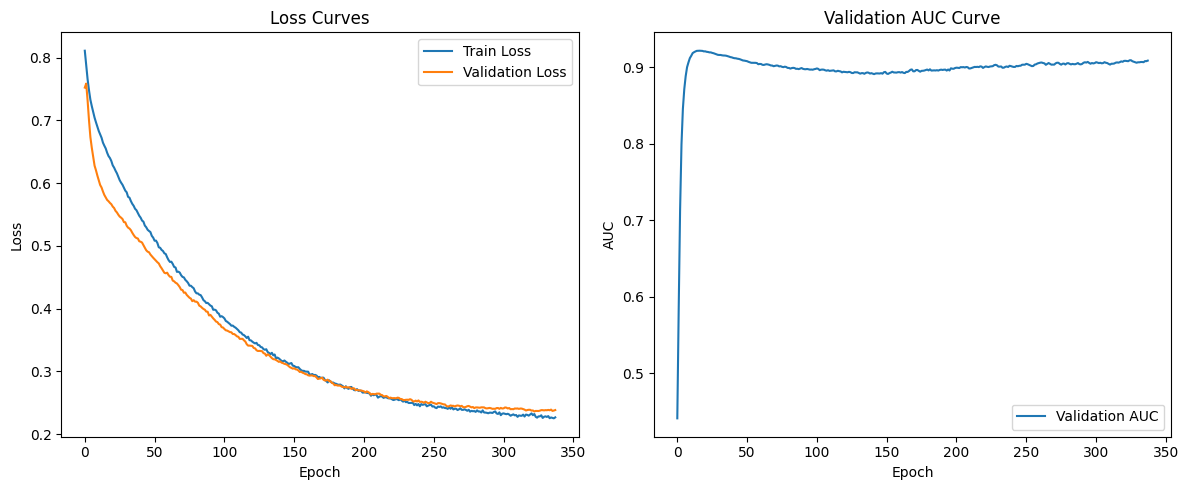

time: 43.2 s (started: 2025-03-31 12:38:32 +00:00)


In [ ]:
def train_neural_network(X_train, y_train, X_val, y_val):
    """Train and evaluate Neural Network model using PyTorch"""
    print("\n==== Neural Network ====")

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train.values)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val.values)

    # Create DataLoader for batching
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor.unsqueeze(1))
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor.unsqueeze(1))

    batch_size = 512
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Define the neural network model
    class RainPredictionNN(nn.Module):
      def __init__(self, input_size=30, hidden_size=32, dropout=0.2):
          super().__init__()
          self.net = nn.Sequential(
              nn.Linear(input_size, hidden_size),
              nn.BatchNorm1d(hidden_size),
              nn.LeakyReLU(0.2),
              nn.Dropout(dropout),

              nn.Linear(hidden_size, hidden_size),
              nn.BatchNorm1d(hidden_size),
              nn.LeakyReLU(0.2),

              nn.Linear(hidden_size, hidden_size//2),
              nn.BatchNorm1d(hidden_size//2),
              nn.LeakyReLU(0.2),

              nn.Linear(hidden_size//2, 1)


          )

      def forward(self, x):
          return torch.sigmoid(self.net(x))

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Initialize model
    input_size = X_train.shape[1]
    model = RainPredictionNN(input_size=input_size).to(device)

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Training loop
    num_epochs =500
    train_losses = []
    val_losses = []
    val_aucs = []
    best_val_loss = float('inf')
    best_model_state = None
    patience = 15
    counter = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * inputs.size(0)

                # Save predictions and targets for AUC calculation
                val_preds.extend(outputs.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Calculate validation AUC
        val_auc = roc_auc_score(np.array(val_targets), np.array(val_preds))
        val_aucs.append(val_auc)

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Load best model
    model.load_state_dict(best_model_state)

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(1, 2, 2)
    plt.plot(val_aucs, label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.title('Validation AUC Curve')
    plt.tight_layout()
    plt.show()

    return model, val_aucs[-1]

# Train Neural Network
nn_model, nn_val_auc = train_neural_network(X_train_scaled, y_train, X_val_scaled, y_val)



=== Evaluating Logistic Regression ===
Validation Accuracy: 0.9073
Validation AUC: 0.9041

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      1066
         1.0       0.78      0.48      0.59       175

    accuracy                           0.91      1241
   macro avg       0.85      0.73      0.77      1241
weighted avg       0.90      0.91      0.90      1241



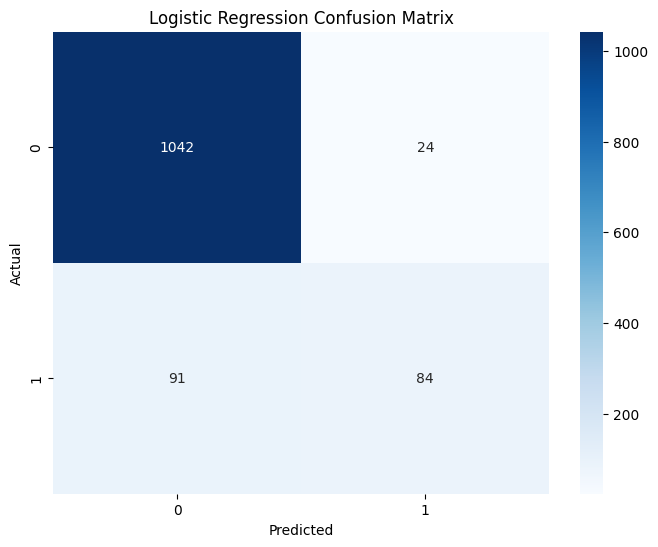


=== Evaluating Decision Tree ===
Validation Accuracy: 0.8832
Validation AUC: 0.8733

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      1066
         1.0       0.59      0.58      0.58       175

    accuracy                           0.88      1241
   macro avg       0.76      0.76      0.76      1241
weighted avg       0.88      0.88      0.88      1241



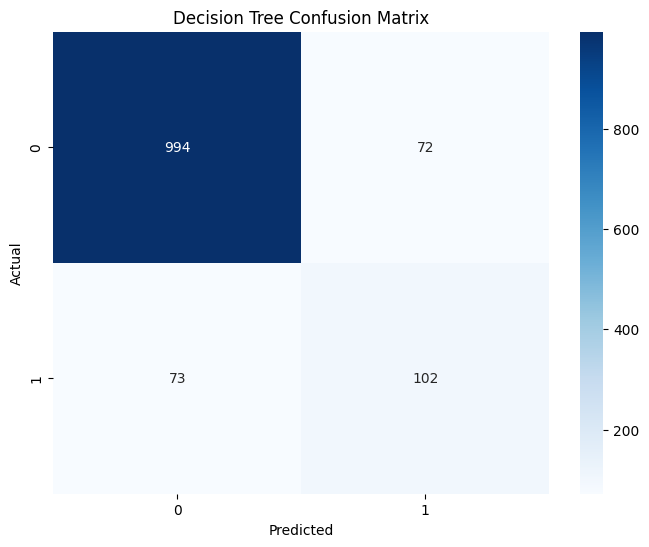


=== Evaluating Random Forest ===
Validation Accuracy: 0.9299
Validation AUC: 0.9279

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      1066
         1.0       0.89      0.58      0.70       175

    accuracy                           0.93      1241
   macro avg       0.91      0.78      0.83      1241
weighted avg       0.93      0.93      0.92      1241



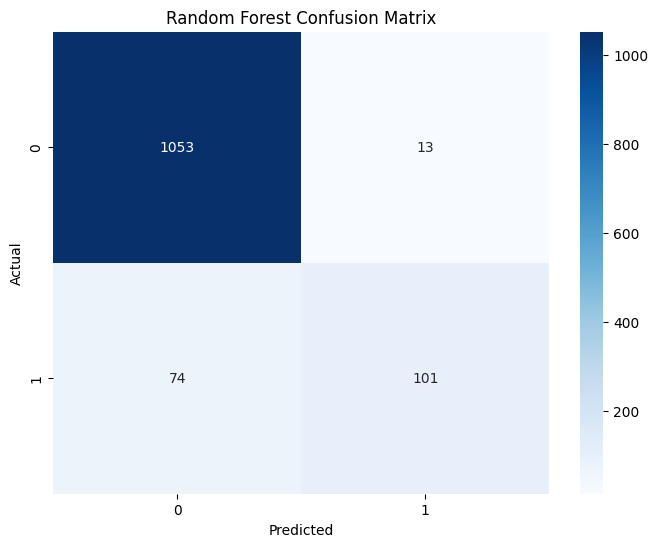


=== Evaluating SVM ===
Validation Accuracy: 0.8904
Validation AUC: 0.8926

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94      1066
         1.0       0.62      0.57      0.60       175

    accuracy                           0.89      1241
   macro avg       0.78      0.76      0.77      1241
weighted avg       0.89      0.89      0.89      1241



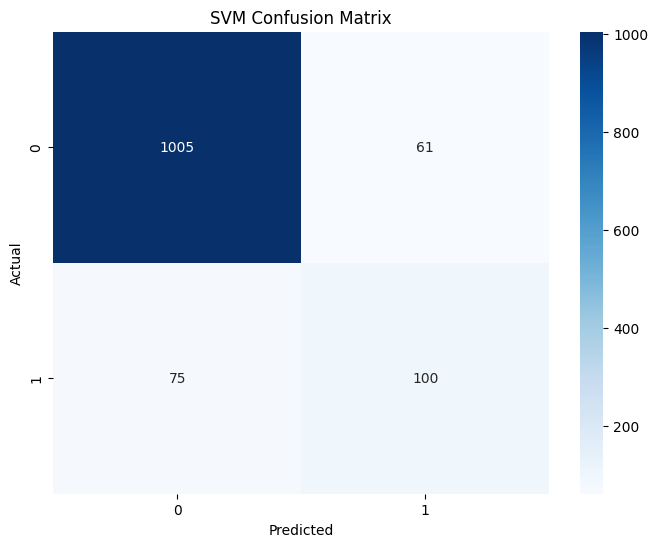


=== Evaluating Neural Network ===
Validation Accuracy: 0.9041
Validation AUC: 0.9085

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94      1066
         1.0       0.67      0.64      0.65       175

    accuracy                           0.90      1241
   macro avg       0.80      0.79      0.80      1241
weighted avg       0.90      0.90      0.90      1241



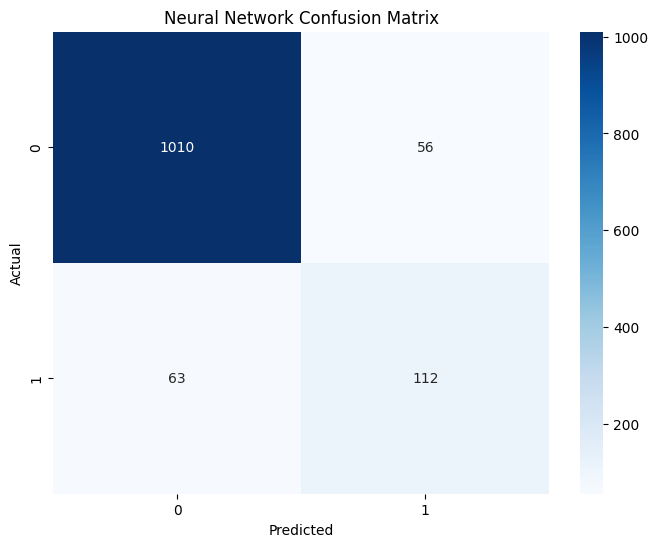

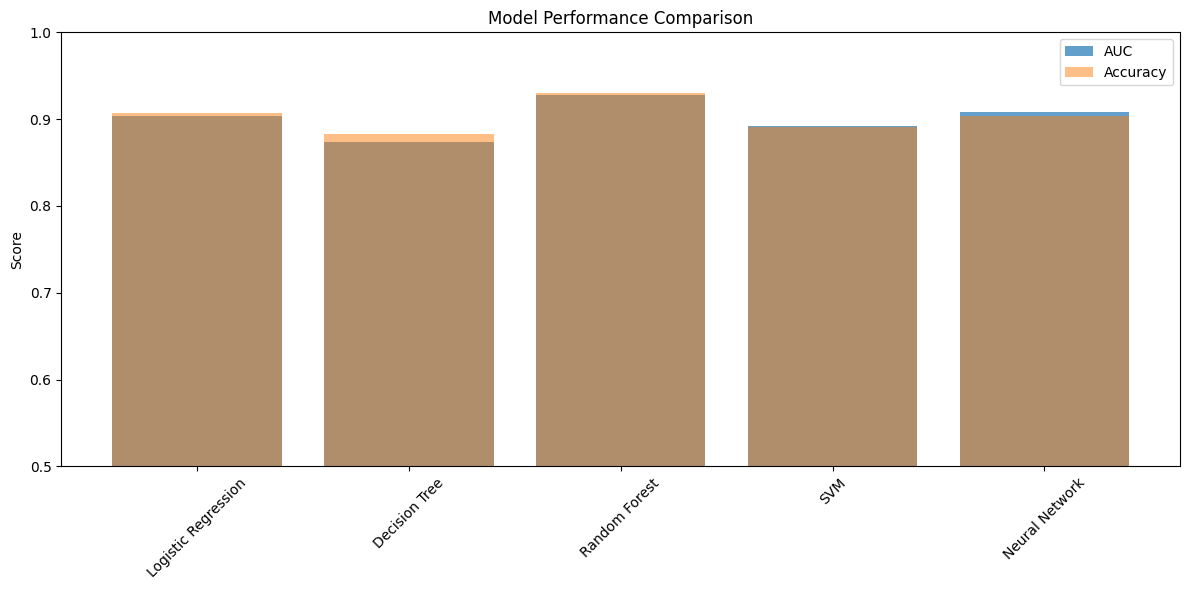

time: 1.33 s (started: 2025-03-31 12:39:15 +00:00)


In [ ]:
def evaluate_model(model, X_val, y_val, model_name):
    """Evaluate a model and show performance metrics"""
    print(f"\n=== Evaluating {model_name} ===")

    # Make predictions
    if model_name == "Neural Network":
        # For neural network
        model, _ = model  # Unpack tuple
        X_val_tensor = torch.FloatTensor(X_val)
        model.eval()

        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_probs = val_outputs.cpu().numpy().flatten()
            val_preds = (val_outputs > 0.5).float().cpu().numpy().flatten()
    else:
        # For sklearn models
        val_preds = model.predict(X_val)
        val_probs = model.predict_proba(X_val)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_val, val_preds)
    auc = roc_auc_score(y_val, val_probs)

    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation AUC: {auc:.4f}")



    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_val, val_preds))

      # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_val, val_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return accuracy, auc

# Evaluate all models
models = {
    'Logistic Regression': lr_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'SVM': svm_model,
    'Neural Network': (nn_model, nn_val_auc)
}

results = {}
for name, model in models.items():
    acc, auc = evaluate_model(model, X_val_scaled, y_val, name)
    results[name] = {'accuracy': acc, 'auc': auc}

# Compare models visually
plt.figure(figsize=(12, 6))
names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in names]
aucs = [results[name]['auc'] for name in names]

# Plot performance comparison
plt.bar(names, aucs, alpha=0.7, label='AUC')
plt.bar(names, accuracies, alpha=0.5, label='Accuracy')
plt.ylim(0.5, 1.0)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Best model: Random Forest
Test Accuracy: 0.8836
Test AUC: 0.9145

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.96      0.93      1254
         1.0       0.63      0.41      0.50       206

    accuracy                           0.88      1460
   macro avg       0.77      0.69      0.72      1460
weighted avg       0.87      0.88      0.87      1460



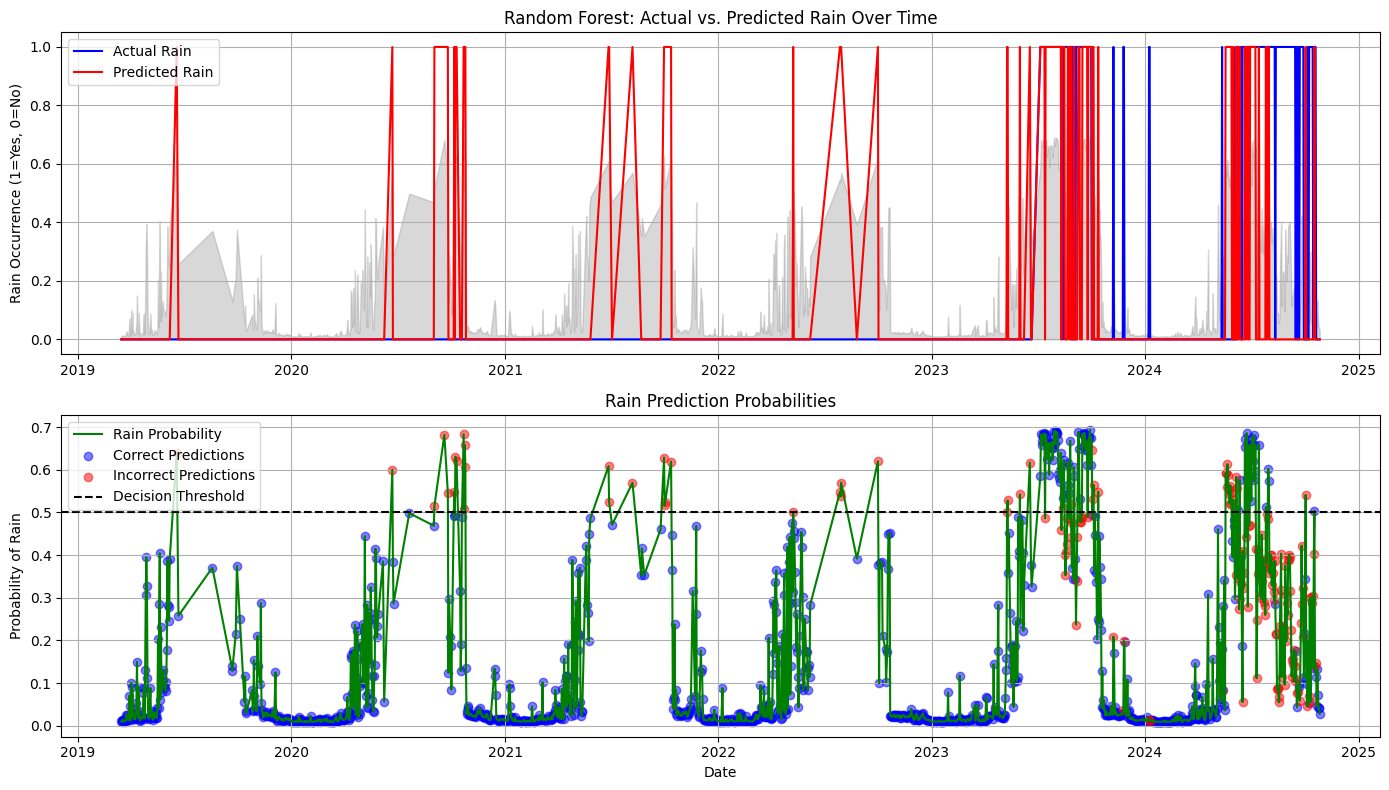

['feature_scaler.pkl']

time: 709 ms (started: 2025-03-31 12:39:17 +00:00)


In [ ]:
# Identify best model
best_model_name = max(results.items(), key=lambda x: x[1]['auc'])[0]
best_model = models[best_model_name]

print(f"\nBest model: {best_model_name}")

# Test on the test set
if best_model_name == "Neural Network":
    model = best_model[0]
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    model.eval()

    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_probs = test_outputs.cpu().numpy().flatten()
        test_preds = (test_outputs > 0.5).float().cpu().numpy().flatten()
else:
    test_preds = best_model.predict(X_test_scaled)
    test_probs = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, test_preds)
test_auc = roc_auc_score(y_test, test_probs)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

print("\nTest Classification Report:")
print(classification_report(y_test, test_preds))

# Visualize predictions over time
results_df = pd.DataFrame({
    'Date': test_df['Date'],
    'Actual': y_test.values,
    'Predicted': test_preds,
    'Probability': test_probs
})

# Group by date to handle multiple predictions per day
daily_results = results_df.groupby('Date').mean()

plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)

plt.plot(daily_results.index, daily_results['Actual'], 'b-', label='Actual Rain')
plt.plot(daily_results.index, daily_results['Predicted'], 'r-', label='Predicted Rain')
plt.fill_between(daily_results.index, daily_results['Probability'], alpha=0.3, color='gray')

plt.title(f'{best_model_name}: Actual vs. Predicted Rain Over Time')
plt.ylabel('Rain Occurrence (1=Yes, 0=No)')
plt.legend()
plt.grid(True)

# Plot prediction probabilities
plt.subplot(2, 1, 2)
plt.plot(daily_results.index, daily_results['Probability'], 'g-', label='Rain Probability')

# Mark correct and incorrect predictions
correct = (daily_results['Actual'] == (daily_results['Probability'] > 0.5).astype(int))
incorrect = ~correct

plt.scatter(
    daily_results.index[correct],
    daily_results['Probability'][correct],
    color='blue', alpha=0.5, label='Correct Predictions'
)

plt.scatter(
    daily_results.index[incorrect],
    daily_results['Probability'][incorrect],
    color='red', alpha=0.5, label='Incorrect Predictions'
)

plt.axhline(y=0.5, color='k', linestyle='--', label='Decision Threshold')

plt.title('Rain Prediction Probabilities')
plt.ylabel('Probability of Rain')
plt.xlabel('Date')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Save the model
import joblib
if best_model_name == "Neural Network":
    torch.save(best_model[0].state_dict(), 'best_rain_prediction_model.pth')
else:
    joblib.dump(best_model, 'best_rain_prediction_model.pkl')

# Save the scaler
joblib.dump(scaler, 'feature_scaler.pkl')


In [ ]:
!pip install torchviz
!pip install pydot


time: 6.34 s (started: 2025-03-31 13:17:40 +00:00)


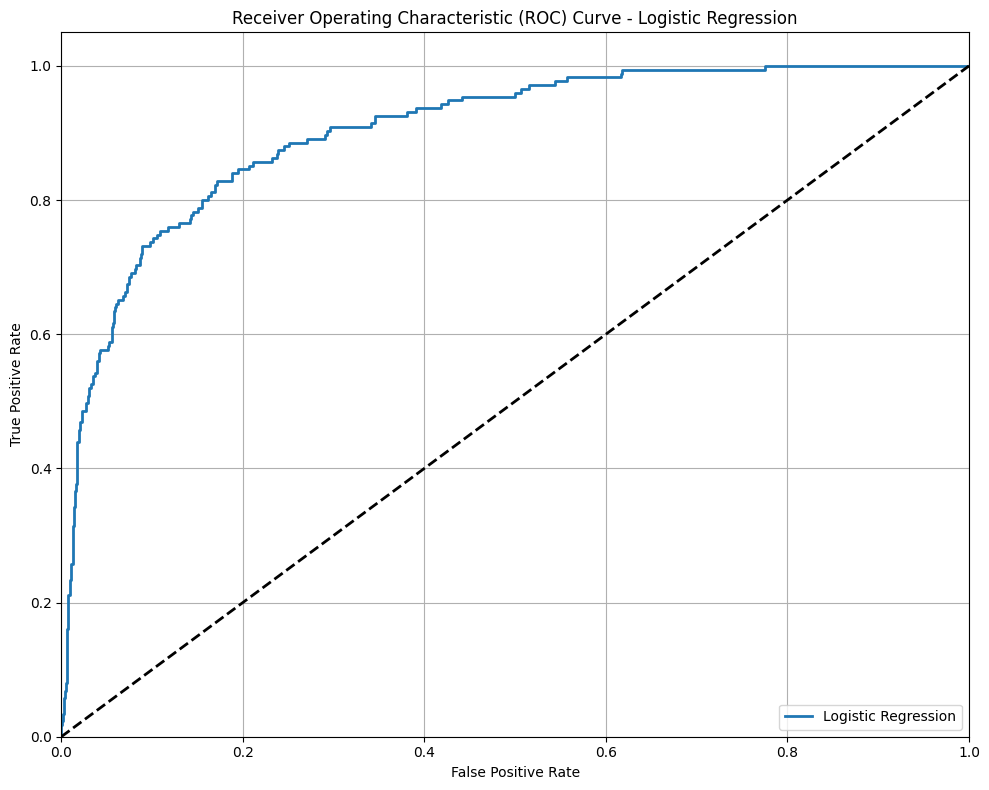

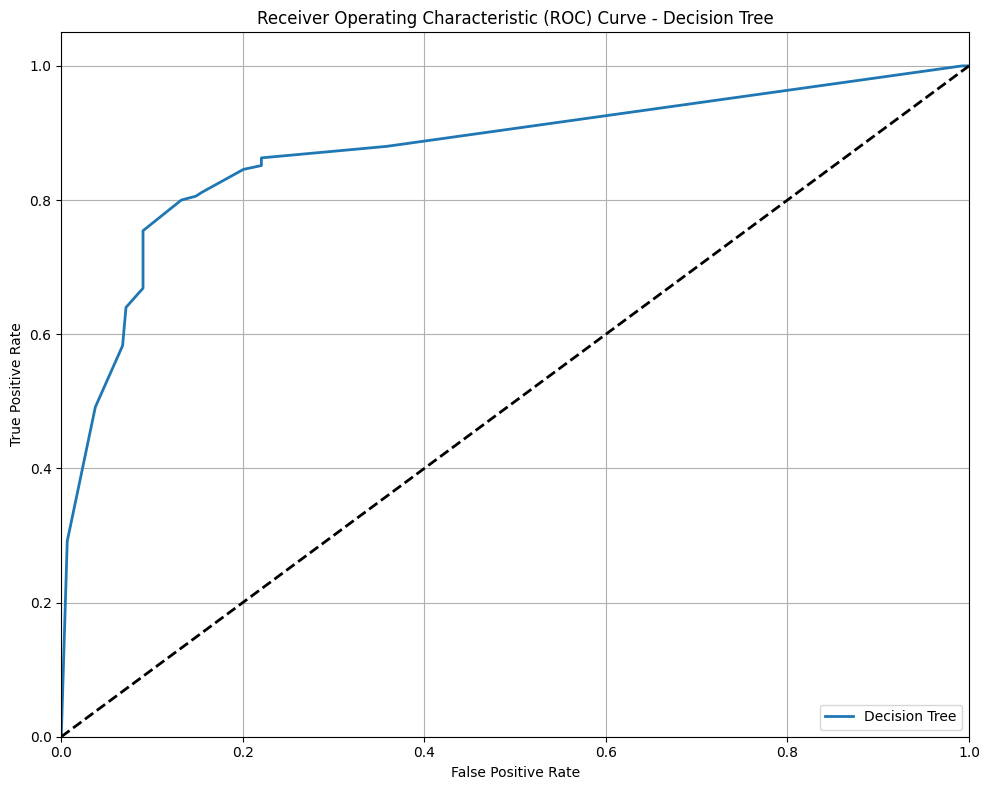

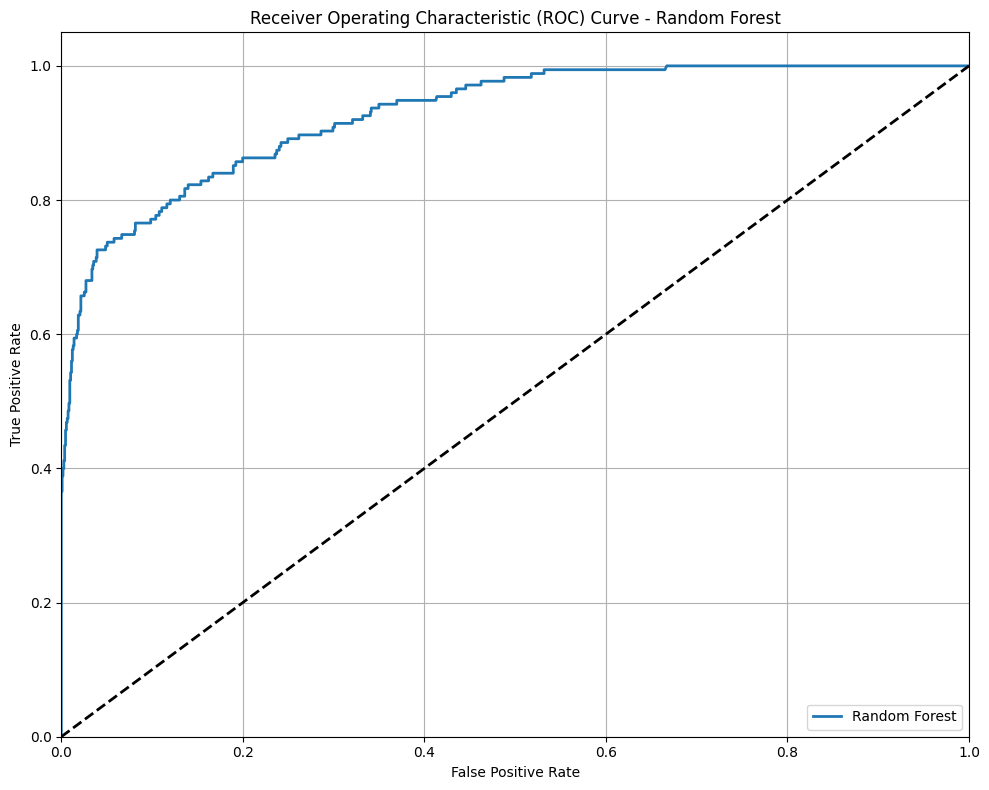

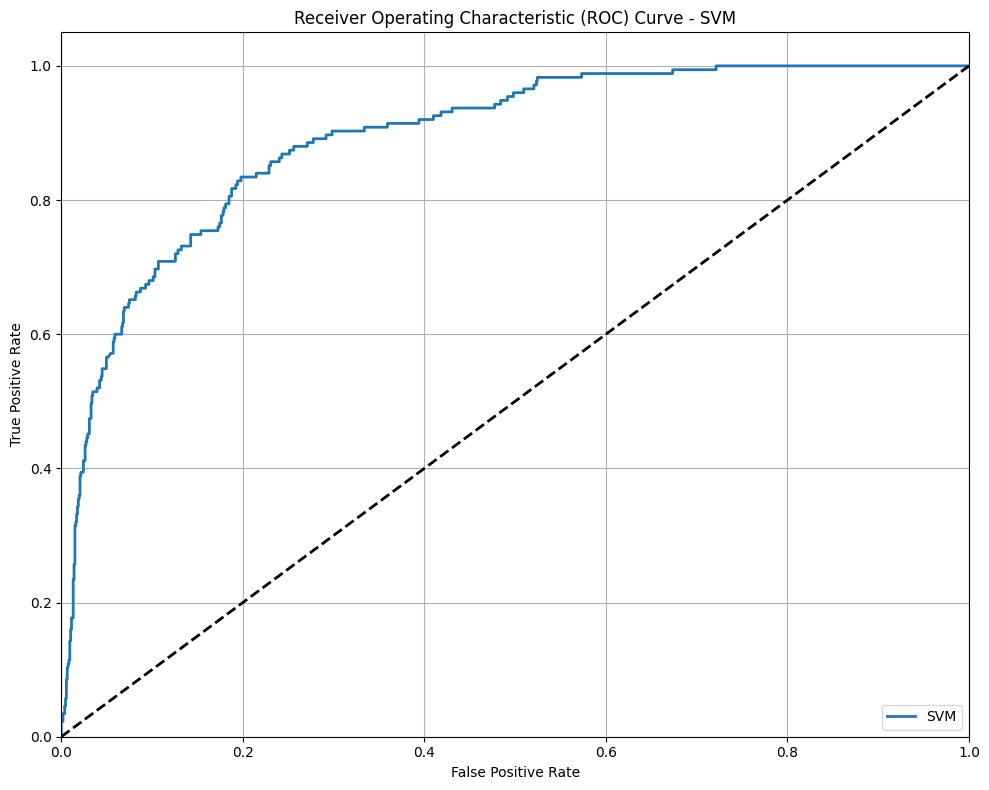

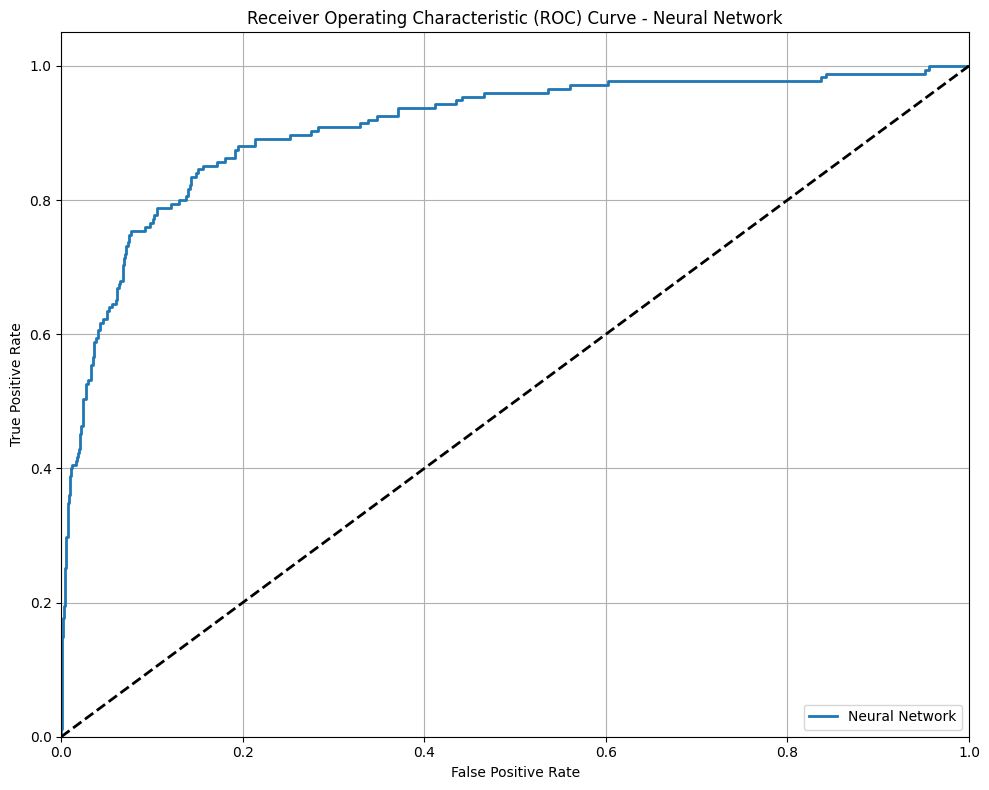

time: 1.72 s (started: 2025-03-31 14:40:25 +00:00)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch

def plot_roc_curves(models, X_val, y_val):
    """Plot ROC curves for all models in separate plots."""

    for name, model in models.items():
        plt.figure(figsize=(10, 8))  # Create a new figure for each model

        if name == "Neural Network":
            # For neural network
            model_nn = model[0]  # Unpack tuple
            X_val_tensor = torch.FloatTensor(X_val)
            model_nn.eval()

            with torch.no_grad():
                val_outputs = model_nn(X_val_tensor)
                val_probs = val_outputs.cpu().numpy().flatten()
        else:
            # For sklearn models
            val_probs = model.predict_proba(X_val)[:, 1]

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_val, val_probs)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{name}')

        # Plot diagonal line (random classifier)
        plt.plot([0, 1], [0, 1], 'k--', lw=2)

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) Curve - {name}')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()

        # Show the plot for the current model
        plt.show()

# Call the function with your models
plot_roc_curves(models, X_val_scaled, y_val)
